<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Agent_based_Model_Communication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent-based Model

What are the conditions that are necessary for developing a predisposition for language? In this notebook, we will model the evolution of communication amongst agents.

Arguably, communication can be grouped in two types of communication:
1. to coordinate cooperation
2. to deceive others for your own gain (hi Macchiavelli)


### Model Assumptions

#### Agent Behaviour

- **Inheritance:** Agents are assumed to inherit a predisposition for how likely they are to communicate and whether they want to harm one another. This will determine the agents' priors:
$P(\text{communicate})$ and $P(\text{malintent})$.
These factors will be determined by the individual's inherited genome. Arbitrarily, I have decided that the DNA sequence is $98$ nucleotides long. The first half determines the prior to communicate, the second half determines the prior to act in bad faith (malintent).

In [8]:
import numpy as np
from itertools import chain
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm
import random

In [9]:
class Agent():
    nucleotides = ["a","t","c","g"]
    def __init__(self, mu: float, parents=None):
        self.parents = parents
        self.dna = np.random.choice(Agent.nucleotides, 98) if parents is None else self.inherit(parents, mu)
        self.malintent, self.communication = self.features_from_dna(self.dna)
        self.prior_malintent = self.malintent/(len(self.dna)/6)
        self.prior_communication = self.communication/(len(self.dna)/6)
        self.food_counter = 5 # initial amount of food reserves an individual is born with
        self.reputation = 1

    # inheritance method
    def inherit(self, parents: tuple, mu: float):
        # inheritance:
        child_dna = []
        for i in range(0, (len(parents[0].dna)-2), 3):
            child_dna.append(list(np.random.choice(parents).dna[i:i+3]))
        # random mutation:
        child_dna = list(chain(*child_dna))
        for i in range(len(child_dna)):
            if st.bernoulli(mu).rvs(1):
                child_dna[i] = random.choice(Agent.nucleotides)
        return child_dna

    # extract features from DNA
    def features_from_dna(self, dna: list):
        communication, malintent = 0, 0
        for i in range(0, len(dna), 3):
            if i < (len(dna)/2):
                # every occurrence of "c,c,t" counts as +1 to malintent feature
                if "".join(dna[i:i+3])=="cct":
                    communication += 1
            else:
                # every occurrence of "g,a,t" counts as +1 to communication feature
                if "".join(dna[i:i+3])=="gat":
                    malintent += 1
        return (malintent, communication)

    # food opportunity interaction:
    def found_food(self, other):
        # decide to communicate or not:
        if st.bernoulli(self.prior_communication).rvs(1):
            # other also has to be willing to communicate
            if st.bernoulli(other.prior_communication).rvs(1):
                # decide to try to steal food or not
                if st.bernoulli(self.prior_malintent).rvs(1):
                    # other has good intentions:
                    if not st.bernoulli(other.prior_malintent).rvs(1):
                        self.food_counter += 3
                    # other also wants to steal the food:
                    else:
                        np.random.choice([self, other]).food_counter += 3
                else:
                    if st.bernoulli(other.prior_malintent).rvs(1):
                        other.food_counter += 3
                    else:
                        # share food:
                        self.food_counter += 1.5
                        other.food_counter += 1.5
                        # increase reputation:
                        self.reputation += 1
                        other.reputation += 1
            else:
                self.food_counter += 1.6
        else:
            self.food_counter += 1.6

    def starve(self):
        starved = self.food_counter < 0
        return starved

    def food_decay(self):
        self.food_counter -= 1.65

    def __str__(self):
        return(
            f"Agent (Parents: {self.parents})\n"
            "##### Features #####\n"
            f"Communication: {self.communication}\n"
            f"Malintent: {self.malintent}\n"
            f"Reputation: {self.reputation}\n"
        )

For example, we can create an agent without inheritance, who gets assigned a random DNA string:

In [ ]:
individual = Agent(mu=0.001)
print(individual)
print(f"Length DNA = {len(individual.dna)}\nDNA: {' '.join(individual.dna)}")

Agent (Parents: None)
##### Features #####
Communication: 0
Malintent: 0
Reputation: 1

Length DNA = 98
DNA: t c g a g c g c a t c c t g c t g g a g g g t g a a c c g a g g a g a c g a a t t t g c t a c t g g g a c g g g t a t a a c g c g a g t a g c c g g g g g t c a t g g c c c t g t a t a c g g a g a


### Inheritance Example
We can create a child from two Agent instances by using the parents argument in the instantiate method. The child's DNA is a result of random choices of DNA triplets from either the father or the mother

In [ ]:
mu = 0.01
mother = Agent(mu)
father = Agent(mu)
child = Agent(mu, parents=(mother, father))

print("Father:")
print(" ".join(father.dna))
print("Mother:")
print(" ".join(mother.dna))
print("Child:")
print(" ".join(child.dna))

Father:
t c c t a g g c g g c a g a g t c g c a g t t g c g a c c t g c c a g a a c c g g c c g t t a t g c g t g t a c g g a c c t c g c a t g t c c a t g g t t t t t c c a c t c g t g t g t c t t t c a
Mother:
c g c g g a c g t a g g g a c c g t g a c g t g g c t a t c c c c c g g g g t t g a g a t c a g c t g g g g c t a c g t g g t t g g c a c g a t a t g a t g g c c g c a a g c c c a c a g g g a g a
Child:
c g c t a g c g t g c a g a c t c g c a g t t g g c t c c t c c c c g g a c c t g a c g t t a t c t g g g g a c g c g t c t c g c a t g t g a t t g g a t g g c c g c a a g c c c a g t c t t t


### Potential Strategies

Before we run the simulation, let us consider how different strategies affect survival chances.

- Strategy 1: Never communicate, always eat alone
- Strategy 2: Always communicate, never try to steal food
- Strategy 3: Always communicate, alway try to steal food

Strategy 2 and Strategy 3 depend on the behaviour of others, therefore we should consider different proportions of others applying Strategy 2 or 3.

Let's assume that during each life cycle an individual has 30 food opportunities (+ the opportunities they get by chance where they communicate to others and they communicate back) and that the population size stays at 30.

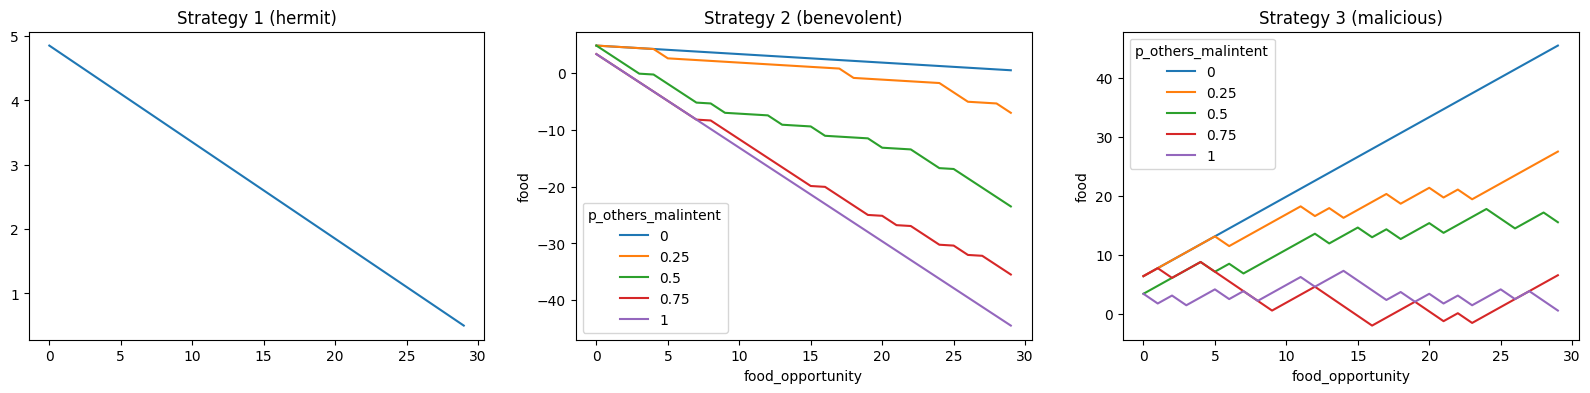

In [ ]:
initial_food = 5
food_decay = 1.65

# Strategy 1
strat_1 =[]
food_count = initial_food
for _ in range(30):
    food_count = food_count + 1.5 - food_decay
    strat_1.append(food_count)

# Strategy 2
strat_2 = pd.DataFrame(columns=["food_opportunity", "p_others_malintent", "food"])
for p_others in [0, 0.25, 0.5, 0.75, 1]:
    food_count = initial_food
    for i in range(30):
        food_count -= food_decay
        if st.bernoulli(p_others).rvs(1):
            pass
        else:
            food_count += 1.5
        strat_2.loc[len(strat_2.index),:] = (i, str(p_others), food_count)

# Strategy 3
strat_3 = pd.DataFrame(columns=["food_opportunity", "p_others_malintent", "food"])
for p_others in [0, 0.25, 0.5, 0.75, 1]:
    food_count = initial_food
    for i in range(30):
        food_count -= food_decay
        if st.bernoulli(p_others).rvs(1):
            if st.bernoulli(0.5).rvs(1):
                food_count += 3
        else:
            food_count += 3
        strat_3.loc[len(strat_3.index),:] = (i, str(p_others), food_count)

# plot strategies:
fig, ax = plt.subplots(1,3, figsize=(20,4))
_ = ax[0].plot(strat_1)
_ = ax[0].set_title("Strategy 1 (hermit)")
_ = sns.lineplot(data=strat_2, x="food_opportunity", y="food", hue="p_others_malintent", ax=ax[1])
_ = ax[1].set_title("Strategy 2 (benevolent)")
_ = sns.lineplot(data=strat_3, x="food_opportunity", y="food", hue="p_others_malintent", ax=ax[2])
_ = ax[2].set_title("Strategy 3 (malicious)")


If agents want to maximize for food only, they should try to communicate as much as possible and they should try to steal food after cooperating for obtaining food (malintent).

## Simulation Loop

### Parameters
- **number of generations**: how many generations the simulation runs
- **population size**: how many individuals are in a generation
- **food opportunities**: how many food opportunities a generation has
- $\mathbf{\mu}$: mutation chance per nucleotide.


|  | Communication | Malintent |
| --- | --- | --- |
| Cost | lower chance of survival | no reputation gain/ lower reproductive chances  |
| Benefit | reputation gain/ higher reproductive chances | higher chance of survival |

The reproductive chances depend on their food counter and their reputation. An agent gains reputation based on their food counter. Additionally, if they communicate positively, they also gain reputation.
$$chances_i = \frac{reputation_i}{\sum_{a \in agents} reptutation_a}$$

For example, if the agents' reputations are 9, 4, 5, 2, the reproductive chances are shown in the graph on the left; if reputations are 5, 5, 5, 5, 5 the reproductive chances are shown in the graph on the right.

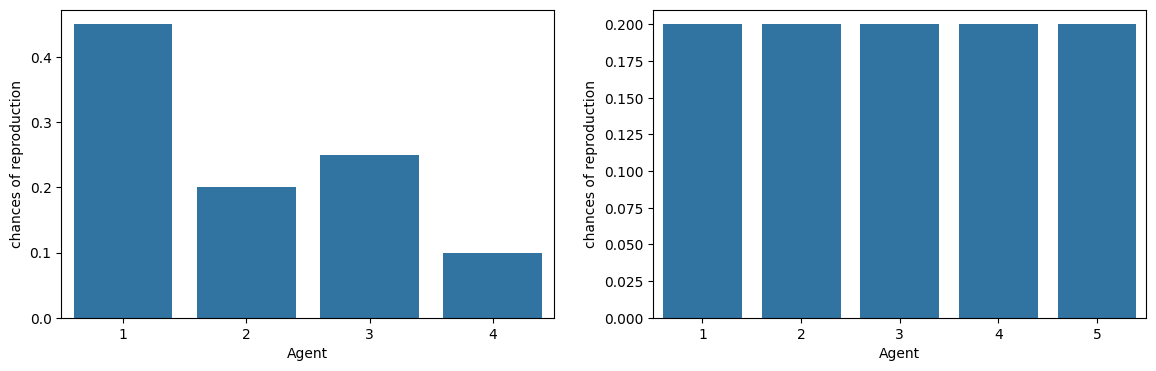

In [ ]:
example_reputations = [[9,4,5,2],[5,5,5,5,5]]
fig, ax = plt.subplots(1,2, figsize=(14,4))
for i, reputations in enumerate(example_reputations):
    total_rep = np.sum(reputations)
    _ = sns.barplot(x=range(1,len(reputations)+1), y=td.Categorical(probs=torch.Tensor([reputation/total_rep for reputation in reputations])).probs, ax=ax[i])
    _ = ax[i].set_xlabel("Agent")
    _ = ax[i].set_ylabel("chances of reproduction")

In [ ]:
def reproduce(population: list[Agent], mu: float, reputation=False, size=1):
    offspring = []
    if reputation:
        if len(population) > 2:
            total_rep = np.sum([agent.reputation for agent in population])
            repr_chances = td.Categorical(probs=torch.Tensor([agent.reputation/total_rep for agent in population])) # agents with higher reputation have higher chances of reproduction
            for _ in range(size):
                parent1 = population[int(repr_chances.sample())]
                while True:
                    parent2 = population[int(repr_chances.sample())]
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    else:
        if len(population) > 2:
            for _ in range(size):
                parent1 = random.choice(population)
                while True:
                    parent2 = random.choice(population)
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    return offspring


def simulate_generation(num_food_opportunities: int, num_generations:int, population_size:int, reputation_reproduction: bool, mu=0.01):
    features = pd.DataFrame(columns=["communication", "malintent", "starvation"])
    current_gen = [Agent(mu) for _ in range(population_size)]
    for gen in tqdm(range(1, (num_generations+1))):
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.food_decay()
                agent.found_food(other=np.random.choice(current_gen))

            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features:
        communication, malintent = [],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
        features.loc[len(features.index)] = [
            np.mean(communication) if len(current_gen)>0 else None,
            np.mean(malintent) if len(current_gen)>0 else None,
            (initial_generation_population_size-len(current_gen)),
            ]

        # simulate reproduction with reputation:
        current_gen = reproduce(current_gen, mu, reputation=reputation_reproduction, size=population_size)

    return features

def plot_simulation_stats(simulation_stats):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    _ = sns.lineplot(data=simulation_stats.loc[:, simulation_stats.columns!="starvation"], ax=ax[0])
    _ = ax[0].set_xlabel("Generation")
    _ = ax[0].set_title("Features")
    _ = ax[0].set_ylim(0,17)
    _ = ax[1].plot(simulation_stats["starvation"])
    _ = ax[1].set_xlabel("Generation")
    _ = ax[1].set_title("Starvation")

100%|██████████| 100/100 [07:54<00:00,  4.75s/it]


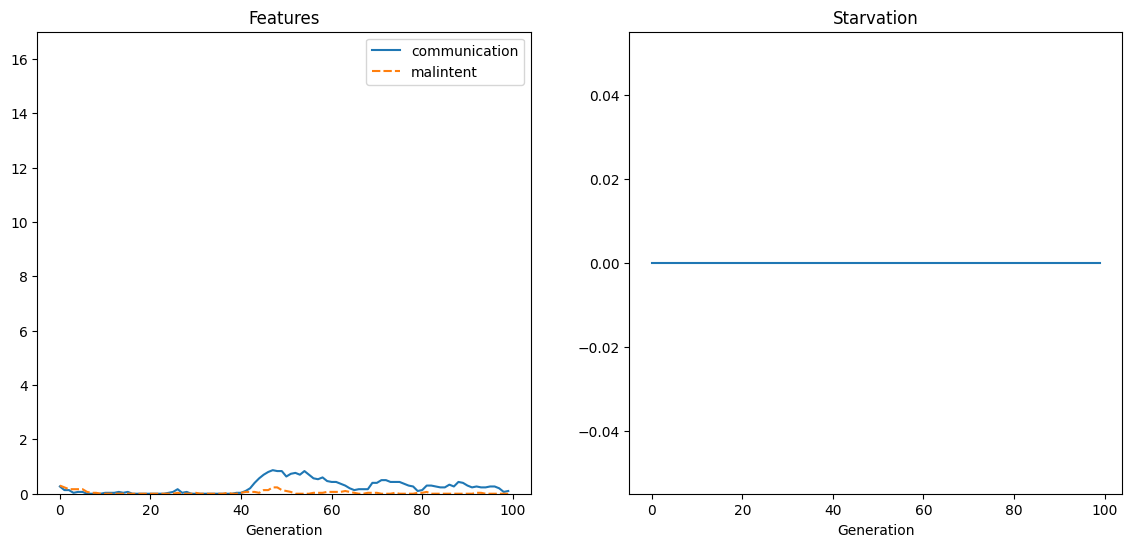

In [ ]:
sim_no_reputation = simulate_generation(num_food_opportunities=30, num_generations=100, population_size=30, reputation_reproduction=False)
plot_simulation_stats(sim_no_reputation)

100%|██████████| 100/100 [13:59<00:00,  8.40s/it]


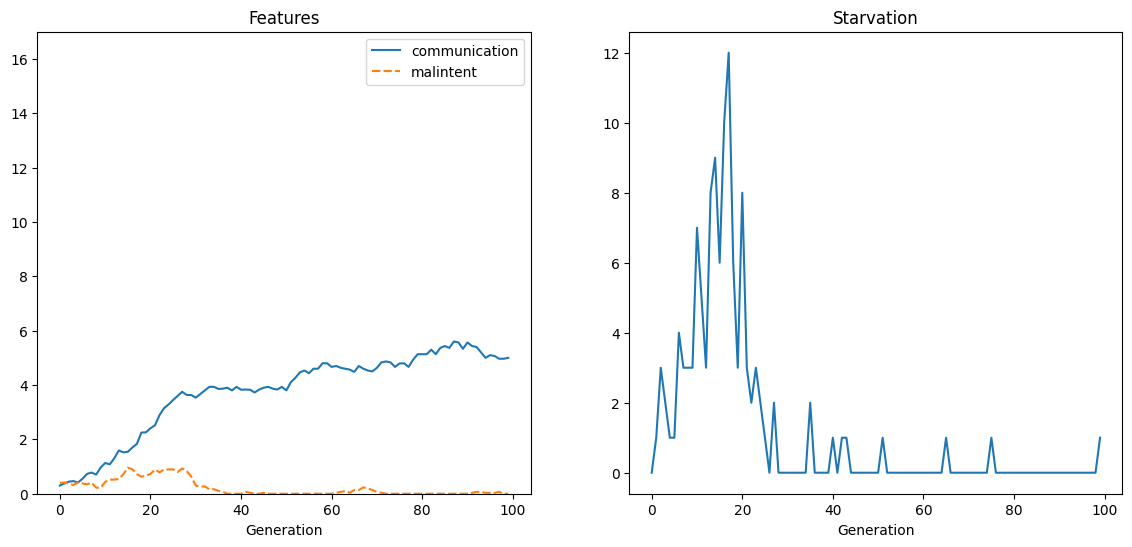

In [ ]:
stats_reputation = simulate_generation(num_food_opportunities=100, num_generations=100, population_size=30, reputation_reproduction=True)
plot_simulation_stats(stats_reputation)

## Adding Bayesian Learning

- **Bayesian Learning:** Agents can also learn from interactions. We will us Bayesian inference updating to model the adaptive learning.
After every communication event, the probability of communication gets updated:
$$ P(communicate|outcome) = \frac{P(communicate)P(outcome|communicate)}{P(outcome)}$$
The simplest way to model this is by counting positive and negative outcomes using a Beta distribution where the prior is distributed as $p(communication) \sim Beta(\alpha=count(outcome=negative), \beta = count(outcome=positive))$

In [26]:
class BayesianAgent(Agent):
    def __init__(self, *args, **kwargs):
        super(BayesianAgent, self).__init__(*args, **kwargs)
        self.log_prior_communication = np.log(self.prior_communication)

    # @todo: implement bayesian learning
    def log_posterior_communication(self, prior, outcome):
        pass
        # update prior

    def log_likelihood_communication(self):
        pass

    def log_marginal_communication(self):
        pass


    # @todo: override found_food method to implement bayesian learning:

    # food opportunity interaction:
    def found_food(self, other):
        # decide to communicate or not:
        if st.bernoulli(self.prior_communication).rvs(1):
            # other also has to be willing to communicate
            if st.bernoulli(other.prior_communication).rvs(1):
                # decide to try to steal food or not
                if st.bernoulli(self.prior_malintent).rvs(1):
                    # other has good intentions:
                    if not st.bernoulli(other.prior_malintent).rvs(1):
                        self.food_counter += 3
                    # other also wants to steal the food:
                    else:
                        np.random.choice([self, other]).food_counter += 3
                else:
                    if st.bernoulli(other.prior_malintent).rvs(1):
                        other.food_counter += 3
                    else:
                        # share food:
                        self.food_counter += 1.5
                        other.food_counter += 1.5
                        # increase reputation:
                        self.reputation += 1
                        other.reputation += 1
            else:
                self.food_counter += 1.6
        else:
            self.food_counter += 1.6

In [25]:
b_agent = BayesianAgent(0.001)
print(b_agent)
print(f'DNA: {" ".join(b_agent.dna)}')

Agent (Parents: None)
##### Features #####
Communication: 1
Malintent: 0
Reputation: 1

DNA: t c c c a c t t c t t t g t c t c g g g t g c c t c a t t a g a t c c t a t c c c g a t a a t t t a t t a g t c a a c t a c c g t a a t c t t c a t c a c a t c g a t g c g t a g g t a t a t a g g


## Adding a Vocabulary